# Feature extraction and spatial analysis

Here, we will load a GTEx Small Intestine slide as example.

In [1]:
from huggingface_hub import hf_hub_download

slide = hf_hub_download(
    "rendeirolab/lazyslide-data", 
    "GTEX-11DXX-1626.svs", 
    repo_type="dataset",
    cache_dir="."
)

In [2]:
from wsidata import open_wsi
import lazyslide as zs

import matplotlib.pyplot as plt

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Let's open the wsi!

WSI: datasets--rendeirolab--lazyslide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
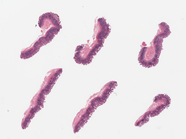

In [3]:
wsi = open_wsi(slide)
wsi

What does the tissue look like?

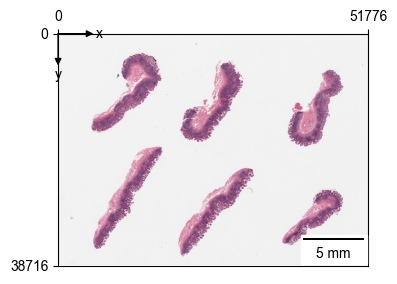

In [4]:
zs.pl.tissue(wsi)

Let's first find and tile the tissue, we will request tiny tile size of 64*64 px, this may take a while.

In [5]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 128)

## Morphological feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. Typically, this is done by feeding the tiles into a vision model.

LazySlide supports automatic mix-precision inference which may reduce memory usuage and have faster inference spped, try `amp=True`. Since we are working on a big slide with tiny tile sizes, this may take 10mins to finish (MacBook M3 Max).

```python
zs.tl.feature_extraction(wsi, "plip", amp=True)
```

::{note}
Autocast doesn't work well with mps backend though, you may get all nan results.

In [ ]:
zs.tl.feature_extraction(wsi, "plip")

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}". For example, `h0-mini_tiles`

## Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide. By default, the mean pooling is applied. Advanced slide encoders will be introduced later.

In [12]:
zs.tl.feature_aggregation(wsi, feature_key="plip")

You can retrieve specific feature with the `fetch` accessor. This will return a copy of the anndata.

In [13]:
adata = wsi.fetch.features_anndata("plip")

## Pre-computed results

If you don't want to run feature extraction, you can simply load the pre-computed one

In [7]:
wsi = zs.datasets.gtex_small_intestine()

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


WSI: /Users/yzheng/.cache/huggingface/hub/datasets--RendeiroLab--LazySlide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /Users/yzheng/.cache/huggingface/hub/datasets--RendeiroLab--LazySlide-data/snapshots/e36d9447830c0dc6c1c54326d4354909fc509e2e/GTEX-11DXX-1626.zarr/GTEX-11DXX-1626.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (19038, 3) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      ├── 'plip_tiles': AnnData (19038, 512)
      └── 'plip_tiles_text_similarity': AnnData (19038, 4)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)
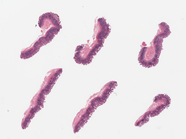

In [14]:
wsi

## Examination of feature space

In [21]:
import scanpy as sc

adata = wsi["plip_tiles"]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)

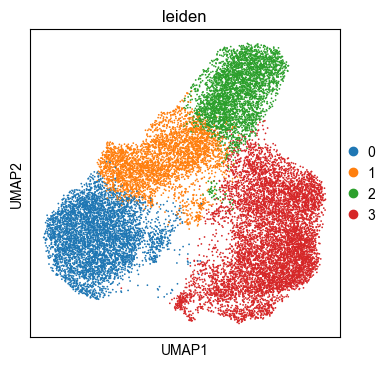

In [26]:
sc.pl.umap(adata, color="leiden")

In [27]:
sc.tl.rank_genes_groups(adata, groupby="leiden")

features = set()
for i in adata.obs["leiden"].unique():
    names = sc.get.rank_genes_groups_df(adata, i).names
    features.update(list(names[0:10]) + list(names[-10:]))
features = list(features)

/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yzheng/Projects/LazySlide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


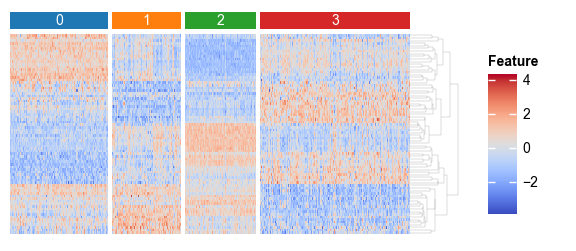

In [31]:
import marsilea as ma
import marsilea.plotter as mp
from scipy.stats import zscore

key = "leiden"
h = ma.Heatmap(zscore(adata[:, features].X.T), height=2, width=4, label="Feature")
order = sorted(adata.obs[key].unique())
h.group_cols(adata.obs[key], order=order)
h.add_top(mp.Chunk(order, fill_colors=adata.uns[f"{key}_colors"], padding=2), pad=0.05)
h.add_dendrogram("right", method="average", linewidth=0.1)
h.add_legends()
h.render()

## Identification of spatial domains

The leiden clustering on features from foundational model can already recover the spatial domains of tissues pretty well.

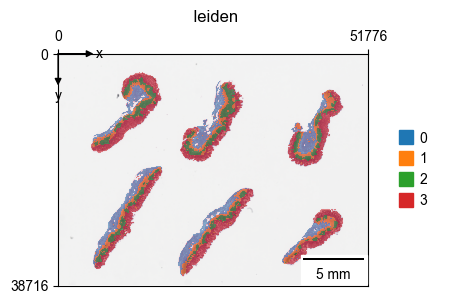

In [33]:
zs.pl.tiles(
    wsi,
    feature_key="plip",
    color="leiden",
    alpha=0.5,
    palette=adata.uns[f"{key}_colors"],
    show_contours=False,
)

For simplicity, you can simply run spatial domain through:

In [34]:
zs.tl.spatial_domain(wsi, feature_key="plip", resolution=0.2)

The spatial domain is equivalent to the following process:

In [ ]:
wsi.write()

### Integration of spatial information with UTAG

In this example, you may notice the border of domain is not very smooth, this can be improved by integrating spatial information.

[UTAG](https://doi.org/10.1038/s41592-022-01657-2) is a method develop to discovery spatial domain with unsupervised learning.

In [35]:
zs.pp.tile_graph(wsi)
zs.tl.spatial_features(wsi, "plip")

In [38]:
zs.tl.spatial_domain(wsi, layer="spatial_features", feature_key="plip", resolution=0.3)

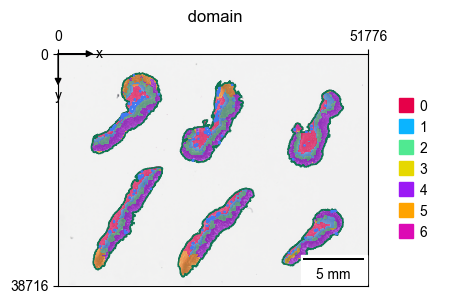

In [39]:
zs.pl.tiles(wsi, color="domain", alpha=0.5)

## Text feature extraction

Apart from deriving morphological features from vision models, you can also run multimodal to derive text features.

Currently, there are two vision-language models for pathology
- [PLIP](https://doi.org/10.1038/s41591-023-02504-3), Nature Medicine, 2023
- [CONCH](https://doi.org/10.1038/s41591-024-02856-4), Nature Medicine, 2024

Since we've extracted the plip vision features for our WSI, we only need to extract features for the texts.

In [42]:
terms = ["mucosa", "submucosa", "musclaris", "lymphocyte"]

In [45]:
embeddings = zs.tl.text_embedding(terms, model="plip")
zs.tl.text_image_similarity(wsi, embeddings, model="plip", softmax=True)

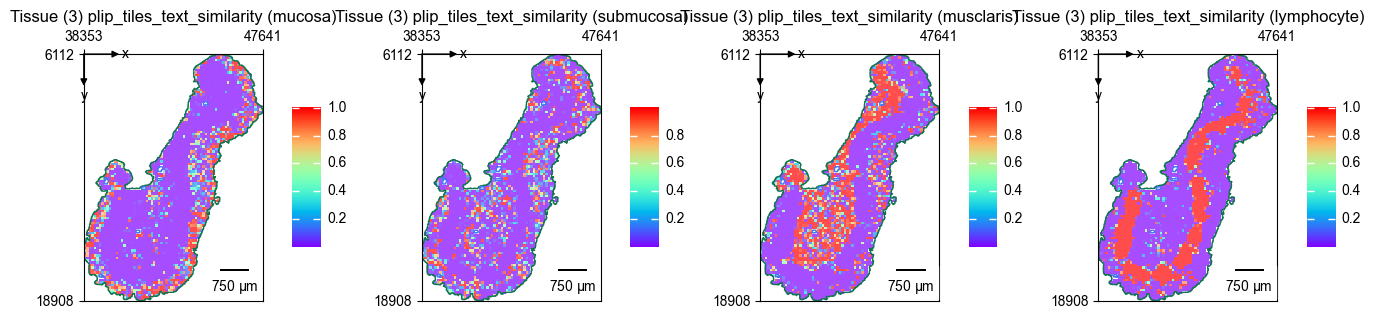

In [43]:
zs.pl.tiles(
    wsi,
    feature_key="plip_tiles_text_similarity",
    color=terms,
    cmap="rainbow",
    show_image=False,
    tissue_id=3,
    alpha=0.7,
)